# Классификация изображений
# Проект 7. Ford vs Ferrari: определяем модель авто по фото 
### Основная идея этого решения: взять предобученую на ImageNet сеть Xception и дообучить под нашу задачу. 


In [2]:
!mkdir /kaggle/temp #папка для временных файлов
!unzip /kaggle/input/train.zip -d /kaggle/temp
!unzip /kaggle/input/test.zip -d /kaggle/temp
sample_submission_path = '/kaggle/input/sample-submission.csv'
train_path = '/kaggle/temp/train/'
sub_path = '/kaggle/temp/test_upload/'
!unzip -q ...

**Работаем с Tensorflow v2**

In [3]:
!pip show  -q
!pip install -q efficientnet
# Загружаем обвязку под keras для использования продвинутых библиотек аугментации, например, albuminations
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor -q

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pickle
import csv
import os
import random
from kaggle_datasets import KaggleDatasets
import zipfile
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.callbacks import Callback
from keras.regularizers import l2
from keras import optimizers
from keras.models import Model
from keras.utils import np_utils
from keras.applications.xception import Xception
from keras.layers import *

import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from keras.callbacks import LearningRateScheduler,EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow  import keras
import efficientnet.tfkeras as efn


from sklearn.model_selection import train_test_split, StratifiedKFold
import csv
import sys
import os
import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

In [5]:
# Checking the GPU.
!nvidia-smi

In [6]:
!pip freeze > requirements.txt

# Основные настройки

In [7]:
sample_submission_path = '/kaggle/input/sample-submission.csv'
train_path = '/kaggle/temp/train/'
sub_path = '/kaggle/temp/test_upload/'

In [8]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 5  # начнем с 5 эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'

PATH = "../working/car/" # рабочая директория
TEMP = '/kaggle/temp/'

In [9]:
# Устаналиваем конкретное значение random seed для воспроизводимости
os.makedirs(PATH ,exist_ok=True)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [10]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip,"r") as z:
        z.extractall(TEMP)
        
print(os.listdir(TEMP))

In [11]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

In [12]:
train_df.info()

In [13]:
train_df.Category.value_counts()

In [14]:
train_df.Category.value_counts().plot(kind='bar')

In [15]:
## распределение классов достаточно равномерное. никак дорабатывать не будем

In [16]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(TEMP+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

In [17]:
image = PIL.Image.open(TEMP+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Подготовка данных

### Аугментация данных

In [18]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations as A

In [19]:
# аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.
# Официальная документация: https://keras.io/preprocessing/image/

#AUGMENTATIONS = albumentations.Compose([
#    albumentations.HorizontalFlip(p=0.5),#Отразите ввод по горизонтали вокруг оси y.
#    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),#Поверните ввод на угол, случайно выбранный из равномерного распределения.
#    albumentations.OneOf([
#        albumentations.CenterCrop(height=220, width=200),# Обрежьте центральную часть входа.
#        albumentations.CenterCrop(height=200, width=220),
#    ],p=0.5),
#    albumentations.OneOf([
#        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),#Произвольно изменяйте яркость и контраст входного изображения.
#        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
#    ],p=0.5),
#    albumentations.GaussianBlur(p=0.05),#Размытие входного изображения с помощью фильтра Гаусса
#    albumentations.HueSaturationValue(p=0.5),# Произвольно меняет оттенок, насыщенность, значение входного изображения.


 #   albumentations.RGBShift(p=0.5),# Произвольно смещайте значения для каждого канала входного изображения RGB.

  #  albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5), #Увеличьте изображение RGB с помощью FancyPCA 
  #  albumentations.Resize(IMG_SIZE, IMG_SIZE)#Измените размер ввода до заданной высоты и ширины.
#])
      
#train_datagen = ImageDataAugmentor(
#        rescale=1./255,
#        augment = AUGMENTATIONS,
#        validation_split=VAL_SPLIT,
#        )

#test_datagen = ImageDataGenerator(rescale=1. / 255)
#Рекомендация Подключите более продвинутые библиотеки аугментации изображений (например: albumentations или imgaug, для них есть специальные "обертки" под Keras, например: https://github.com/mjkvaak/ImageDataAugmentor)

In [20]:
#################################### new
AUGMENTATIONS = A.Compose([
    A.GaussianBlur(p=0.05),
    A.RandomBrightness(limit=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, 
                       scale_limit=0.01, 
                       interpolation=1, 
                       border_mode=4, 
                       rotate_limit=20, 
                       p=.75),
    A.OneOf([
        A.CenterCrop(height=224, width=200),
        A.CenterCrop(height=200, width=224)],
        p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.RGBShift(p=0.5),
    A.FancyPCA(alpha=0.1, 
               always_apply=False, 
               p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])
####################################
#изменила
train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )

test_datagen = ImageDataGenerator(rescale=1. / 255)

### Генерация данных

In [21]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    TEMP+'train/',      # директория где расположены папки с картинками 
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True, seed=RANDOM_SEED,
    subset = 'training') # set as training data

test_generator = train_datagen.flow_from_directory(
    TEMP+'train/',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle= True, seed=RANDOM_SEED,
    subset= 'validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe = sample_submission,
    directory = TEMP+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# Обратите внимание, что для сабмита мы используем другой источник test_datagen.flow_from_dataframe. Как вы думаете, почему?

In [22]:
# изображения после аугментации

from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

x,y = train_generator.next() # вызываем трейн-генератор
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,3):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    
plt.show()

Callbackss

In [23]:
x,y = test_generator.next() 
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,3):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    
plt.show()

In [24]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

# Построение модели

### Загружаем предобученную сеть Xception:

In [25]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [26]:
base_model.summary()

In [27]:
# Чтобы хорошо обученные признаки на Imagenet не затирались в самом начале нашего обучения,обучим только "голову", 
#для этого заморозим веса Xception 
base_model.trainable = False

In [28]:
# Устанавливаем новую "голову" (head)

model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),) # объединяем все признаки в единый вектор 


model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [29]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [30]:
# сколько слоев
print(len(model.layers))
len(model.trainable_variables)
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

Обучение

In [31]:
# Обучаем

history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

In [32]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [33]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [35]:
test_sub_generator.samples

In [36]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [37]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_xception61.23%.csv', index=False)
print('Save submit')

обучение половины весов FineTuning

In [38]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

In [39]:
#base_model.trainable = True

# Fine-tune from this layer onwards
#fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
#for layer in base_model.layers[:fine_tune_at]:
    #layer.trainable =  False

In [40]:
#len(base_model.trainable_variables)

In [41]:
# Check the trainable status of the individual layers
#for layer in model.layers:
    #print(layer, layer.trainable)

In [42]:
#EPOCHS               = 15  # эпох на обучение
#BATCH_SIZE           = 32 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU

In [43]:
#model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [44]:
# Обучаем
#history = model.fit(
        #train_generator,
        #steps_per_epoch = len(train_generator),
        #validation_data = test_generator, 
        #validation_steps = len(test_generator),
        #epochs = EPOCHS,
        #callbacks = callbacks_list
#)

In [45]:
#model.save('../working/model_last_xc.hdf5')
#model.load_weights('best_model.hdf5')

In [46]:
#scores = model.evaluate_generator(test_generator, verbose=1)
#print("Accuracy: %.2f%%" % (scores[1]*100))

Submission

In [47]:
#test_sub_generator.samples

In [48]:
#test_sub_generator.reset()
#predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
#predictions = np.argmax(predictions, axis=-1) #multiple categories
#label_map = (train_generator.class_indices)
#label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
#predictions = [label_map[k] for k in predictions]

In [49]:
#filenames_with_dir=test_sub_generator.filenames
#submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
#submission['Id'] = submission['Id'].replace('test_upload/','')
#submission.to_csv('submissionv_xc.csv', index=False)
#print('Save submissionv_xc')

In [50]:
#submission.head()

### Загружаем предобученную сеть "efficient-b5" без батч нормализации

In [51]:
base_model1 = efn.EfficientNetB5(weights='imagenet', include_top=False, input_shape = input_shape)

In [52]:
base_model1.summary()

обучение половины весов FineTuning¶


In [53]:
#base_model1.trainable = False
base_model1.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model1.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model1.layers[:fine_tune_at]:
    layer.trainable =  False

In [54]:
model=M.Sequential()
model.add(base_model1)
model.add(L.GlobalAveragePooling2D(),) # объединяем все признаки в единый вектор 


model.add(L.Dense(256, activation='relu'))
model.add(L.Dropout(0.25))
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [55]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [56]:
# сколько слоев
print(len(model.layers))
len(model.trainable_variables)
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

In [57]:
model.summary()

In [58]:
EPOCHS = 15  # 12 эпох на обучение

In [59]:
# Обучаем

history = model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

In [60]:
model.save('../working/model_last_efn5.hdf5')
model.load_weights('best_model.hdf5')

In [61]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [62]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [63]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submission')

из двух использованных сетей Xception И EfficientNetB5 лучший результат дает второй.
так же была настроена аугментация

In [64]:
submission.head()

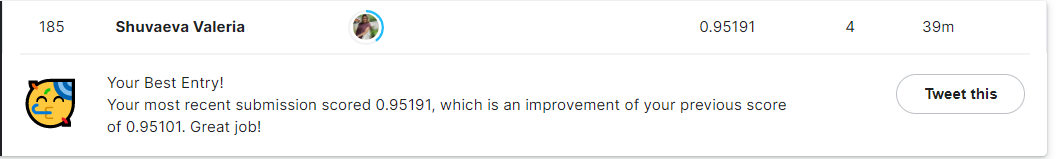